In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

def arc_patch(center, radius, theta1, theta2, ax=None, resolution=50, **kwargs):
    # make sure ax is not empty
    if ax is None:
        ax = plt.gca()
    # generate the points
    theta = np.linspace(np.radians(theta1), np.radians(theta2), resolution)
    points = np.vstack((radius*np.cos(theta) + center[0], 
                        radius*np.sin(theta) + center[1]))
    # build the polygon and add it to the axes
    poly = mpatches.Polygon(points.T, closed=True, **kwargs)
    ax.add_patch(poly)
    return poly

In [2]:
def plot_dual_bubble(ax,pos=[0,0],left_percentage=50, radio=1, use_palette=True, palette=None,left_color='cornflowerblue', right_color='hotpink', reverse_color=False):
    percentage=left_percentage    
    angle=90-(90/50)*percentage
    if palette is not None and use_palette == True:
        cmap = matplotlib.cm.get_cmap(palette, 2)
        left_color = cmap(0)
        right_color = cmap(1)
    if left_color is None:
        left_color = 'cornflowerblue'
    if right_color is None:
       right_color = 'hotpink'
    if reverse_color == True:
        tmp = left_color
        left_color = right_color
        right_color = tmp
    arc_patch((pos[0],pos[1]), radio, 270-angle, 90+angle, ax=ax, fill=True, color=left_color)
    arc_patch((pos[0],pos[1]), radio, -90-angle, 90+angle, ax=ax, fill=True, color=right_color)

In [3]:
! pip install matplotlib
! pip install pymunk

     |████████████████████████████████| 980 kB 12.7 MB/s 


In [4]:
import pymunk
from pymunk.vec2d import Vec2d
import pymunk.matplotlib_util
import numpy as np

from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns


def bubble_plot(
    ax,
    df,
    position_column,
    radius_column,
    label_column=None,
    color_column=None,
    palette="plasma",
    n_bins=10,
    num_steps=50,
    x_position_scaling=800,
    min_label_size=4,
    max_label_size=64,
    starting_y_range=None,
    margin=2,
    dual=False,
    dual_reverse_color=False,
    dual_use_palette=None,
    dual_left_color=None,
    dual_right_color=None
):
    df = df.reset_index()
    space = pymunk.Space()
    space.gravity = (0, 0)

    radius = np.sqrt(df[radius_column].values) + margin

    if starting_y_range is None:
        starting_y_range = int(np.sqrt(df.shape[0]))

    for idx, row in df.iterrows():
        x = row[position_column] * x_position_scaling
        y = np.random.randint(-starting_y_range, starting_y_range)
        mass = 10
        r = radius[idx]

        moment = pymunk.moment_for_circle(mass, 0, r, (0, 0))

        body = pymunk.Body(mass, moment)

        body.position = x, y
        body.start_position = Vec2d(*body.position)

        shape = pymunk.Circle(body, r)
        shape.elasticity = 0.9999999

        space.add(body, shape)

    for i in range(num_steps):
        space.step(1)

    value_range = (min(radius), max(radius))

    def scale(value):
        result = (value - value_range[0]) / (value_range[1] - value_range[0])
        return result

    ax.set_aspect("equal")

    cmap = ListedColormap(sns.color_palette(palette, n_colors=n_bins))

    collection = []
    values = []
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    for body, (idx, row) in zip(space.bodies, df.iterrows()):
        circle = next(iter(body.shapes))
        c = Circle(np.array(body.position), circle.radius - margin)
        collection.append(c)
        values.append(row[position_column])

        body_x = body.position.x
        body_min_x = body_x - circle.radius
        body_max_x = body_x + circle.radius

        body_y = body.position.y
        body_min_y = body_y - circle.radius
        body_max_y = body_y + circle.radius

        if body_min_y < min_y:
            min_y = body_min_y

        if body_min_x < min_x:
            min_x = body_min_x

        if body_max_y > max_y:
            max_y = body_max_y

  
        if body_max_x > max_x:
            max_x = body_max_x

        if dual == True:
            plot_dual_bubble(ax,
                         pos=list(body.position),
                         radio=circle.radius,
                         #left_percentage=100-100*(body.position.x-min_x)/(max_x-min_x)
                         #left_percentage=row.M*100
                         left_percentage= 100-100 * (row[position_column]+1)/2,
                         reverse_color = dual_reverse_color,
                         left_color = dual_left_color,
                         right_color = dual_right_color,
                         palette = palette,
                         use_palette = dual_use_palette
                         )
        if label_column is not None:
            label_size = int(scale(radius[idx]) * max_label_size)
            if label_size < min_label_size:
                continue
            ax.annotate(
                row[label_column],
                np.array(body.position),
                ha="center",
                va="center",
                fontsize=label_size,
            )

    collection = PatchCollection(collection, color="pink", edgecolor="none", cmap=cmap)
    collection.set_array(np.array(values))
    ax.add_collection(collection)

    ax.set_aspect("equal")
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])

    return space, collection

In [5]:
! wget https://raw.githubusercontent.com/zorzalerrante/aves/master/data/external/guaguas/1920-2020.csv

--2021-10-14 18:10:49--  https://raw.githubusercontent.com/zorzalerrante/aves/master/data/external/guaguas/1920-2020.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21216240 (20M) [text/plain]
Saving to: ‘1920-2020.csv’

1920-2020.csv       100%[===================>]  20.23M  --.-KB/s    in 0.1s    

2021-10-14 18:10:51 (199 MB/s) - ‘1920-2020.csv’ saved [21216240/21216240]



In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

def tfidf(df, norm="l1", smooth_idf=False):
    return pd.DataFrame(
        TfidfTransformer(norm=norm, smooth_idf=smooth_idf).fit_transform(df).todense(),
        index=df.index,
        columns=df.columns,
    )

In [7]:
import pandas as pd
guaguas = pd.read_csv('1920-2020.csv')
guaguas.head()

,anio,nombre,sexo,n,proporcion
0,1920,Aaron,M,1,0.000049
1,1920,Abdolina,F,1,0.000049
2,1920,Abdon,M,1,0.000049
3,1920,Abdón,M,2,0.000098
4,1920,Abel,M,11,0.000540


In [8]:
total_n = guaguas.groupby('nombre')['n'].sum().sort_values(ascending=False)
total_n
unisex_names = (
    pd.pivot_table(guaguas, index="nombre", columns="sexo", values="n", aggfunc="sum")
    .join(total_n)
    .fillna(0)
    .assign(mult=lambda x: x["F"] * x["M"])
    .pipe(lambda x: x[(x["mult"] > 0) & (x["n"] > 50)])
    .drop(["mult", "n"], axis=1)
    .pipe(tfidf)
    .pipe(lambda x: x[x["F"].between(0.02, 0.98)])
    .join(total_n)
)

unisex_names.sample(15)

,F,M,n
nombre,,,
Eliz,0.843137,0.156863,51
Ivis,0.973684,0.026316,152
Joey,0.083333,0.916667,60
Newen,0.024194,0.975806,124
Luan,0.211896,0.788104,269
Kay,0.625000,0.375000,120
Noris,0.967949,0.032051,156
Jany,0.971698,0.028302,106
Louis,0.031447,0.968553,159


In [9]:
unisex_names["tendency"] = unisex_names["F"] - unisex_names["M"]
unisex_names.describe()

,F,M,n,tendency
count,619.000000,619.000000,619.000000,619.000000
mean,0.478375,0.521625,351.516963,-0.043251
std,0.384391,0.384391,1180.778528,0.768782
min,0.020000,0.020080,51.000000,-0.960000
25%,0.071429,0.082207,72.000000,-0.857143
50%,0.422819,0.577181,110.000000,-0.154362
75%,0.917793,0.928571,220.500000,0.835586
max,0.979920,0.980000,18042.000000,0.959839


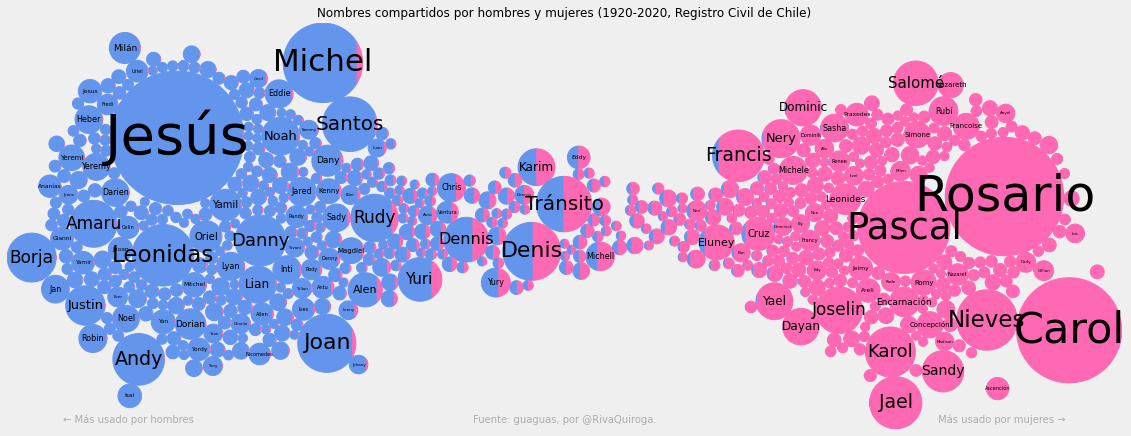

In [10]:

import matplotlib.pyplot as plt
import matplotlib
fig, ax = plt.subplots(figsize=(16, 9))

bubble_plot(
    ax,
    unisex_names.reset_index(),
    "tendency",
    "n",
    label_column="nombre",
    palette="cool",
    dual = True,
    dual_reverse_color = False,
    dual_use_palette = False,
    max_label_size=56,
    starting_y_range=60, margin=2
)

ax.set_axis_off()
ax.set_title(
    "Nombres compartidos por hombres y mujeres (1920-2020, Registro Civil de Chile)"
)
ax.annotate(
    "Más usado por mujeres →",
    (0.95, 0.01),
    xycoords="axes fraction",
    ha="right",
    va="bottom",
    fontsize="medium",
    color="#abacab",
)
ax.annotate(
    "← Más usado por hombres",
    (0.05, 0.01),
    xycoords="axes fraction",
    ha="left",
    va="bottom",
    fontsize="medium",
    color="#abacab",
)
ax.annotate(
    "Fuente: guaguas, por @RivaQuiroga.",
    (0.5, 0.01),
    xycoords="axes fraction",
    ha="center",
    va="bottom",
    fontsize="medium",
    color="#abacab",
)

fig.set_facecolor("#efefef")
fig.tight_layout()